In [1]:
import psycopg2
import pandas as pd
import xmltodict
import numpy as np



In [28]:
# fetch data from the database that's going to be enhanced

#pull data from the database
con = psycopg2.connect("dbname='nytimes'") 
cur = con.cursor()    
cur.execute("SELECT * FROM amazon")
rows = cur.fetchall()
con.close()

# import as a dataframe
amazon_data = pd.DataFrame(data = rows, columns=('id', 'title', 'author', 'description', 'nodelist', 'isbn' ) )

In [29]:
# take the nodelist and convert into a set
counter = 0
for junk_node in amazon_data['nodelist']:
    list_node = eval(junk_node)
    if type(list_node) == dict:
        list_node = set()
#    amazon_data['nodelist'].loc[counter] = list_node
    counter += 1

In [32]:
#pull data from the nyt table in the database
con = psycopg2.connect("dbname='nytimes'") 
cur = con.cursor()    
cur.execute("SELECT * FROM books")
rows = cur.fetchall()
con.close()

# import as a dataframe
nyt_data = pd.DataFrame(data = rows, columns=('id','title', 'isbn', 'author', 'list', 'rank', 'date', 'weeks on list', 'description', 'contributor', 'publisher', 'updated frequency' ) )
len(nyt_data)

40406

In [30]:
# trim out the extra quotes
counter = 0
for node_set in amazon_data['nodelist']:
    node_set = eval(node_set)
    z = set()
    for x in node_set:
        y = x.strip("\'")
        z.add(y)
    amazon_data['nodelist'].loc[counter] = z
    counter += 1
        
        
        
        

In [33]:
fiction = nyt_data[nyt_data['list'] == 'Combined Hardcover & Paperback Fiction']

In [31]:
amazon_data['nodelist']

0      set([Holocaust, Orphans & Foster Homes, Contem...
1      set([Reference, Africa, Orphans & Foster Homes...
2      set([Comic Strips, Self-Help & Psychology, Gra...
3      set([Humor, Memoirs, Actors & Entertainers, Sa...
4                                         set([Fantasy])
5      set([DC Comics, Superheroes, Science Fiction &...
6                        set([Other Diets, Weight Loss])
7      set([Literary, United States, Race Relations, ...
8      set([Friendship, Being a Teen, Contemporary, D...
9                   set([Literary, Drawn and Quarterly])
10             set([Health Policy, Death, Hospice Care])
11             set([Training, Training & Behavior Aids])
12     set([Beginner Readers, Pets, Poetry, Dr. Seuss...
13               set([Contemporary, Contemporary Women])
14                                 set([Memoirs, Women])
15            set([Comics & Graphic Novels, Friendship])
16              set([Literary, Religion & Spirituality])
17               set([Great Bri

In [36]:
fiction = fiction[['title', 'isbn', 'rank', 'date']]
fiction['score' ] = 6-fiction['rank']
#fiction

In [37]:
set_of_fiction = set(amazon_data['isbn']).intersection(set(fiction['isbn']))

In [38]:
fiction[fiction['isbn'] == '0399157689']

,title,isbn,rank,date,score
23835,STOLEN PREY,0399157689,4,2012-05-26,2
23936,STOLEN PREY,0399157689,4,2012-05-19,2


In [39]:
def get_nodes_from_isbn(isbn): 
    index = amazon_data[amazon_data['isbn'] == isbn]['nodelist'].index[0]
    value = amazon_data['nodelist'][index]
    return value



isbn_nodes_dict = dict()

for isbn in set_of_fiction:
    isbn_nodes_dict[isbn] = get_nodes_from_isbn(isbn)

In [40]:
start_date = min(fiction['date'])
end_date = max(fiction['date'])
all_dates = set(fiction['date'])
sorted(all_dates)

print start_date
print end_date
print len(all_dates)

2011-01-30
2013-04-27
118


In [41]:
node_df = pd.DataFrame(columns = [['node']+ sorted(all_dates)])

In [44]:
member_freq_dict = dict()

# go through each isbn
for key in isbn_nodes_dict.keys():
    # go through each set for each isbn
    for member in isbn_nodes_dict[key]:
        # if this set already existed         
        if member in member_freq_dict.keys():
            member_freq_dict[member] += 1
        else:
            member_freq_dict[member] = 1

member_freq_dict

{'Action & Adventure': 6,
 'Adventure': 3,
 'Alternate History': 1,
 'Anatomy': 1,
 'Assassinations': 7,
 'Carpet & Carpet Tiles': 1,
 'Christmas': 1,
 'Classics & Allegories': 1,
 'Cognitive Psychology': 1,
 'Coming of Age': 1,
 'Conspiracies': 3,
 'Contemporary': 23,
 'Contemporary Women': 12,
 'Crime': 6,
 'Culinary': 1,
 'Cultural Heritage': 1,
 'Domestic Life': 2,
 'Dystopian': 2,
 'Epic': 7,
 'Espionage': 3,
 'Family Life': 4,
 'Family Saga': 7,
 'Fantasy': 4,
 'Financial': 1,
 'French': 1,
 'Friendship': 2,
 'Genetic Engineering': 1,
 'Heist': 1,
 'Historical': 8,
 'Horror': 3,
 'Humor': 2,
 'Humor & Satire': 2,
 'Humorous': 4,
 'Jewish': 1,
 'Kidnapping': 1,
 'Legal': 4,
 'Literary': 18,
 'Literature & Fiction': 2,
 'Medical': 1,
 'Metaphysical & Visionary': 3,
 'Military': 5,
 'Murder': 12,
 'Mystery': 15,
 'Mystery & Suspense': 1,
 'Neuropsychology': 1,
 'Occult': 2,
 'Organized Crime': 2,
 'Paranormal': 8,
 'Paranormal & Urban': 9,
 'Police Procedurals': 2,
 'Political': 11,

In [45]:
fiction.values

array([['THE HIT', '1455521213', 1, '2013-04-27', 5],
       ['WHISKEY BEACH', '0399159894', 2, '2013-04-27', 4],
       ['FLY AWAY', '0312577214', 3, '2013-04-27', 3],
       ..., 
       ['THE GIRL WHO PLAYED WITH FIRE', '030745455X', 3, '2011-01-30', 3],
       ['THE GIRL WHO KICKED THE HORNETS NEST', '030726999X', 4,
        '2011-01-30', 2],
       ['MARRYING DAISY BELLAMY', '0778329259', 5, '2011-01-30', 1]], dtype=object)

In [46]:
fiction.values[:,4]

array([5, 4, 3, 2, 1, 5, 4, 3, 2, 1, 5, 4, 3, 2, 1, 5, 4, 3, 2, 1, 5, 4, 3,
       2, 1, 5, 4, 3, 2, 1, 5, 4, 3, 2, 1, 5, 4, 3, 2, 1, 5, 4, 3, 2, 1, 5,
       4, 3, 2, 1, 5, 4, 3, 2, 1, 5, 4, 3, 2, 1, 5, 4, 3, 2, 1, 5, 4, 3, 2,
       1, 5, 4, 3, 2, 1, 5, 4, 3, 2, 1, 5, 4, 3, 2, 1, 5, 4, 3, 2, 1, 5, 4,
       3, 2, 1, 5, 4, 3, 2, 1, 5, 4, 3, 2, 1, 5, 4, 3, 2, 1, 5, 4, 3, 2, 1,
       5, 4, 3, 2, 1, 5, 4, 3, 2, 1, 5, 4, 3, 2, 1, 5, 4, 3, 2, 1, 5, 4, 3,
       2, 1, 5, 4, 3, 2, 1, 5, 4, 3, 2, 1, 5, 4, 3, 2, 1, 5, 4, 3, 2, 1, 5,
       4, 3, 2, 1, 5, 4, 3, 2, 1, 5, 4, 3, 2, 1, 5, 4, 3, 2, 1, 5, 4, 3, 2,
       1, 5, 4, 3, 2, 1, 5, 4, 3, 2, 1, 5, 4, 3, 2, 1, 5, 4, 3, 2, 1, 5, 4,
       3, 2, 1, 5, 4, 3, 2, 1, 5, 4, 3, 2, 1, 5, 4, 3, 2, 1, 5, 4, 3, 2, 1,
       5, 4, 3, 2, 1, 5, 4, 3, 2, 1, 5, 4, 3, 2, 1, 5, 4, 3, 2, 1, 5, 4, 3,
       2, 1, 5, 4, 3, 2, 1, 5, 4, 3, 2, 1, 5, 4, 3, 2, 1, 5, 4, 3, 2, 1, 5,
       4, 3, 2, 1, 5, 4, 3, 2, 1, 5, 4, 3, 2, 1, 5, 4, 3, 2, 1, 5, 4, 3, 2,
       1, 5,

In [47]:
# create empty numpy array in which to store everything full of zeros
row_count = len(member_freq_dict)
col_count = len(all_dates)
x = np.zeros((row_count,col_count))

#so that i can index it 
node_index = dict(zip(member_freq_dict.keys(), range(0,row_count)))
date_index = dict(zip(sorted(all_dates),range(0,col_count)))

In [53]:
for row in fiction.values:
    isbn = row[1]
    if isbn in isbn_nodes_dict.keys():
        nodes_set = isbn_nodes_dict[isbn]
        for member in nodes_set:
            x_index = node_index[member]
            date = row[3]
            y_index = date_index[date]
            x[x_index,y_index] = x[x_index,y_index] + row[4]
        
        

In [67]:
node_df = pd.DataFrame(data = np.transpose(x), index = sorted(all_dates), columns = member_freq_dict.keys())

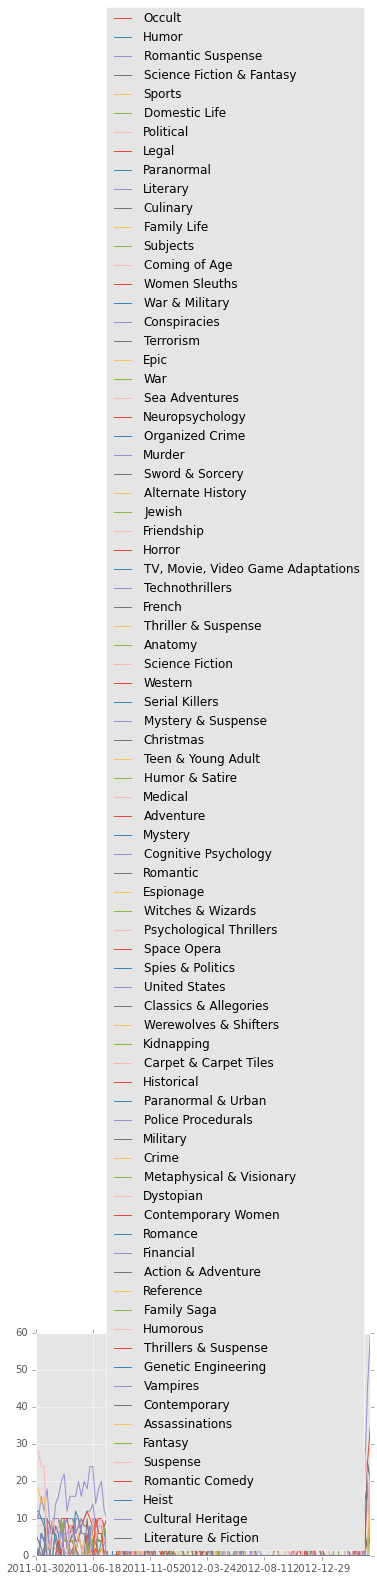

In [70]:
node_df.plot()

In [114]:
node_hist = dict()
for node_set in amazon_data['nodelist']:
    for node in node_set:
        if node in node_hist.keys():
            node_hist[node] += 1
        else:
            node_hist[node] = 1

In [125]:
just_martian = nyt_data [nyt_data['title'] == 'THE MARTIAN']



In [128]:
from datetime import datetime
from dateutil import parser

def format_dates(column):
    formatted_dates = list()
    for date in column:
        x = parser.parse(date)
        formatted_dates.append(x)
    return formatted_dates

just_martian['date'] = format_dates(just_martian['date'])

/Users/noahburbank/anaconda/envs/py2/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [130]:
nyt_data['date'] = format_dates(nyt_data['date'])

In [64]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')

plt.scatter(formatted_dates, just_martian['rank'], color = 'red')

NameError: name 'formatted_dates' is not defined

In [134]:
start_date = min(nyt_data['date'])
end_date = max(nyt_data['date'])
all_dates = set(nyt_data['date'])


In [152]:
print len(nyt_data['title'].unique())
sum(nyt_data.duplicated(('title')))

5063


35343

In [140]:
book_data = pd.DataFrame(columns = ('title', 'amazon_description', 'nyt_description', 'node'))

In [142]:
book_data['title'] = nyt_data['title'].unique()

In [143]:
for title in book_data['title']:
    print title

THE MARTIAN
THE MURDER HOUSE
AFTER YOU
MAKE ME
THE GIRL IN THE SPIDER'S WEB
KILLING REAGAN
WHY NOT ME?
FURIOUSLY HAPPY
THE BOYS IN THE BOAT
BETWEEN THE WORLD AND ME
THE AERONAUT'S WINDLASS
BEING MORTAL
MEMORY MAN
THE ALCHEMIST
GREY
GRAY MOUNTAIN
WILLOW BROOK ROAD
JACK KENNEDY
COLD COLD HEART
DOWN THE RABBIT HOLE
I AM MALALA
YES PLEASE
IT IS ABOUT ISLAM
KILLING LINCOLN
PRETTY GIRLS
THE TUDORS
THE SWEET LIFE IN PARIS
THE LIFE-CHANGING MAGIC OF TIDYING UP
BIG MAGIC
THE 20/20 DIET
RISING STRONG
THE FIVE LOVE LANGUAGES
THE DAY THE CRAYONS CAME HOME
PETE THE CAT: FIVE LITTLE PUMPKINS
THE RABBIT WHO WANTS TO FALL ASLEEP
THE DAY THE CRAYONS QUIT
WHAT PET SHOULD I GET?
WONDER
THE ISLE OF THE LOST
AUGGIE & ME
SERAFINA AND THE BLACK CLOAK
CRENSHAW
MAX
A LONG WALK TO WATER
THE ONE AND ONLY IVAN
OUT OF MY MIND
THE CARE AND KEEPING OF YOU
THE KEEPER
THE FINISHER
HITLER'S LAST DAYS
SIX OF CROWS
EVERYTHING, EVERYTHING
RED QUEEN
ELEANOR AND PARK
FANGIRL
PAPER TOWNS
THE 5TH WAVE
THE BOOK THIEF
LOOKING F

In [174]:
row_range = amazon_data['title'] ==  'The Martian (Mass Market MTI): A Novel'

martian_description = amazon_data[row_range]['description'][65]

In [179]:
# load nltk's SnowballStemmer as variabled 'stemmer'
import nltk
import re
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

In [213]:
import sys  

reload(sys)  
sys.setdefaultencoding('utf8')


utf_martian = martian_description.encode('utf-8')

In [215]:
import html2text

y = html2text.html2text(utf_martian)

y_1 = re.sub('\n', '', y)
y_2 = re.sub('\'' , '', y_1)

print y
print
print y_1
print 
print y_2



In [217]:
tokenize_and_stem(y)

[u'six',
 u'day',
 u'ago',
 u'astronaut',
 u'mark',
 u'watney',
 u'becam',
 u'one',
 u'of',
 u'the',
 u'first',
 u'peopl',
 u'to',
 u'walk',
 u'on',
 u'mar',
 u'now',
 u'he',
 u"'s",
 u'sure',
 u'he',
 u'll',
 u'be',
 u'the',
 u'first',
 u'person',
 u'to',
 u'die',
 u'there',
 u'after',
 u'a',
 u'dust',
 u'storm',
 u'near',
 u'kill',
 u'him',
 u'and',
 u'forc',
 u'his',
 u'crew',
 u'to',
 u'evacu',
 u'while',
 u'think',
 u'him',
 u'dead',
 u'mark',
 u'find',
 u'himself',
 u'strand',
 u'and',
 u'complet',
 u'alon',
 u'with',
 u'no',
 u'way',
 u'to',
 u'even',
 u'signal',
 u'earth',
 u'that',
 u'he',
 u'alive\u2014and',
 u'even',
 u'if',
 u'he',
 u'could',
 u'get',
 u'word',
 u'out',
 u'his',
 u'suppli',
 u'would',
 u'be',
 u'gone',
 u'long',
 u'befor',
 u'a',
 u'rescu',
 u'could',
 u'arriv',
 u'chanc',
 u'are',
 u'though',
 u'he',
 u'wo',
 u"n't",
 u'have',
 u'time',
 u'to',
 u'starv',
 u'to',
 u'death',
 u'the',
 u'damag',
 u'machineri',
 u'unforgiv',
 u'environ',
 u'or',
 u'plain-old'

In [221]:
print utf_martian

In [219]:
print
print 